In [101]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import cm
from tqdm import tqdm
from numpy import linalg as LA

import urllib
from urllib.error import HTTPError
from deap import tools

%matplotlib inline

## Benchmark functions

In [2]:
# Sphere function (minimum at 0)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified
def objective_function_F1a(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1b(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1c(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])


# Rastrigin function (minimum at 0)
def objective_function_F6(X):
    return - 10.0 * X.shape[1] - np.sum(X**2, axis=1) + 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)


# Schwefel function (minimum at 420.9687)
# (REMARK: should be considered only on [-500, 500]^d, because there are better minima outside)
def objective_function_F7(X):
    return - 418.9829 * X.shape[1] + np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)


# Griewank function (minimum at 0)
def objective_function_F8(X):
    return - 1 - np.sum(X**2 / 4000, axis=1) + np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

## Ploting

In [3]:
def plot_3D_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(12, 8))
    ax = plt.gca(projection='3d')
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.hot, linewidth=0, antialiased=True)
    plt.title(title)
    plt.show()

In [4]:
def plot_mutation(
    objective_function,
    mutations,
    original_individual,
    title,
    domain_X = np.arange(-5, 5, 0.25), 
    domain_Y = np.arange(-5, 5, 0.25),
):
   
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

    plt.figure(figsize=(7, 7))
    plt.contour(X, Y, Z, 50)
    plt.scatter(mutations[:, 0], mutations[:, 1], edgecolor='black')
    plt.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24, color='red')
    plt.title(title)
    plt.show()

## Mutation 1
$x_i = x_i + \varepsilon_i$,  $\varepsilon_i$ ~ $\mathcal{N}(0, \sigma^2)$,  $\sigma$ fixed for all $i = 1, 2, \ldots, d$

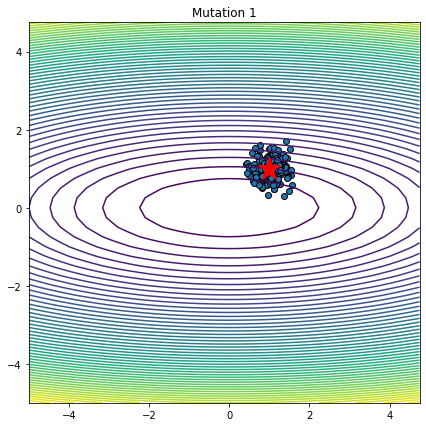

In [5]:
N = 250
d = 2
sigma = 0.25

original_individual = np.array([[1, 1]])
mutations1 = original_individual + sigma * np.random.randn(N, d)

plot_mutation(
    objective_function = objective_function_F1a,
    mutations = mutations1,
    original_individual = original_individual,
    title = 'Mutation 1',
    domain_X = np.arange(-5, 5, 0.25), 
    domain_Y = np.arange(-5, 5, 0.25),
)

## Mutation 2

$x_i = x_i + \varepsilon_i$,  $\varepsilon_i$ ~ $\mathcal{N}(0, \sigma^2)$,  $\sigma$ can be different for all $i = 1, 2, \ldots, d$

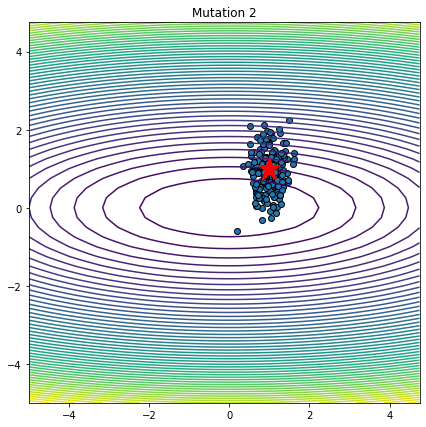

In [6]:
N = 250
d = 2
sigma = np.array([0.25, 0.5])

original_individual = np.array([[1, 1]])
mutations2 = original_individual + sigma * np.random.randn(N, d)


plot_mutation(
    objective_function = objective_function_F1a,
    mutations = mutations2,
    original_individual = original_individual,
    title = 'Mutation 2',
    domain_X = np.arange(-5, 5, 0.25), 
    domain_Y = np.arange(-5, 5, 0.25),
)

## Mutation 3

$\mathbf{x} = \mathbf{x} + \boldsymbol{\varepsilon}$, where $\boldsymbol{\varepsilon}$ has multidimentional normal distribution $\mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma})$

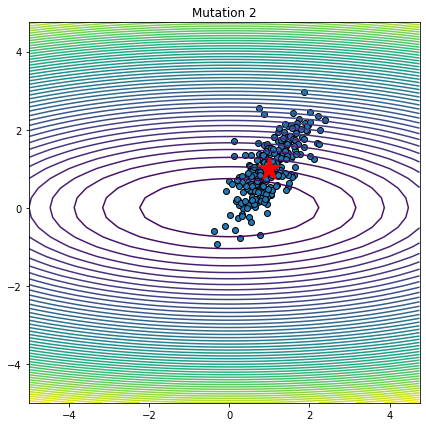

In [7]:
N = 250
d = 2
sigma = np.array([0.25, 0.5])

original_individual = np.array([[1, 1]])
S = np.array([[0.25, 0.25],[0.25, 0.5]])
mutations3 = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)


plot_mutation(
    objective_function = objective_function_F1a,
    mutations = mutations3,
    original_individual = original_individual,
    title = 'Mutation 2',
    domain_X = np.arange(-5, 5, 0.25), 
    domain_Y = np.arange(-5, 5, 0.25),
)

## Describe mutations

In [8]:
def test_mutation(
    mutation,
    objective_function,
    original_individual,
):
    scores = objective_function(mutation)
    original_individual_score = objective_function(original_individual)
    
    better_indi = np.sum(scores > original_individual_score)
    best_indi = scores.max()
    worst_indi = scores.min()
    mean_indi = scores.mean()
    print(f'Better individuals after mutation {better_indi} / {mutation.shape[0]}')
    print(f'Best score: {best_indi} | Worst: {worst_indi} | Mean {mean_indi}')
    print()
    
    
    
def plot_elipses(
    ax,
    mutations, 
    original_individual,
    n_std=2,
    facecolor='none',
    **kwargs
):
    x, y = mutations.T
    cov = np.cov(x, y)
    pearson = cov[0, 1]/(np.sqrt(cov[0, 0] * cov[1, 1])+1e-10)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse(
        (0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs
    )

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
#     fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1)
    
#     ax.scatter(mutations[:, 0], mutations[:, 1], edgecolor='black')
#     ax.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24, color='red')
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
#     plt.show()

In [9]:
original_individual = np.array([[1, 1]])
mutations = [mutations1, mutations2, mutations3]
objective_functions = [
    objective_function_F1, 
    objective_function_F1a, 
    objective_function_F1b, 
    objective_function_F1c,
]

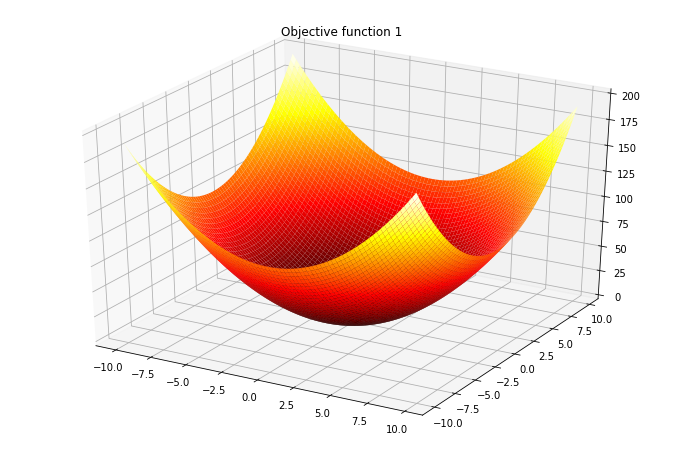

Mutation 1
Better individuals after mutation 128 / 250
Best score: -1.8118937709473513 | Worst: -28.204652719981784 | Mean -10.466152530142123



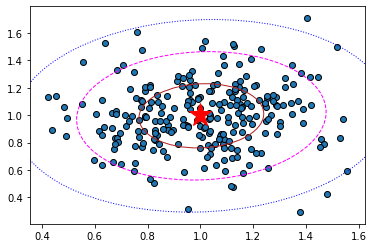

Mutation 2
Better individuals after mutation 130 / 250
Best score: -0.45726073319509974 | Worst: -47.65761767450104 | Mean -11.280615686159793



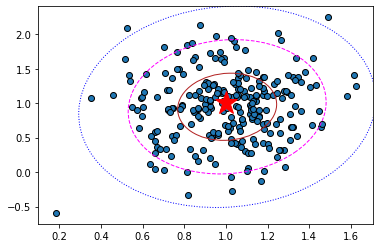

Mutation 3
Better individuals after mutation 127 / 250
Best score: -0.09800172367626361 | Worst: -82.3552823836624 | Mean -14.527399488881468



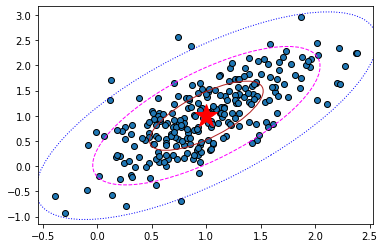

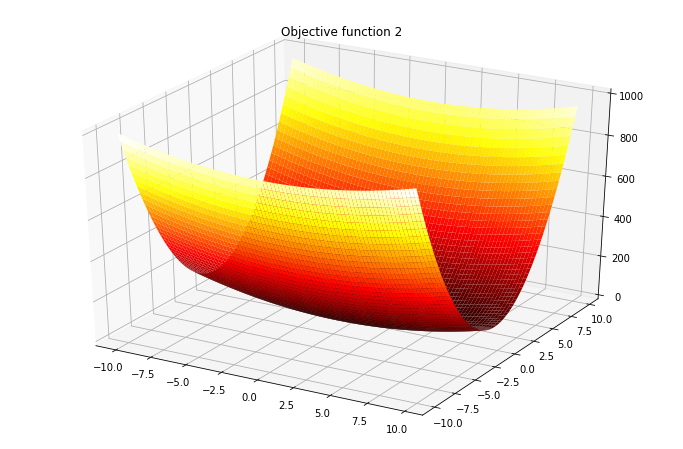

Mutation 1
Better individuals after mutation 128 / 250
Best score: -1.8118937709473513 | Worst: -28.204652719981784 | Mean -10.466152530142123



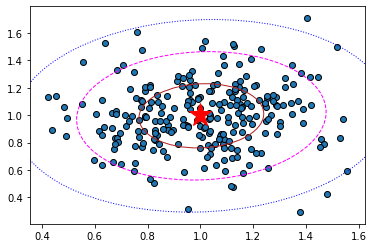

Mutation 2
Better individuals after mutation 130 / 250
Best score: -0.45726073319509974 | Worst: -47.65761767450104 | Mean -11.280615686159793



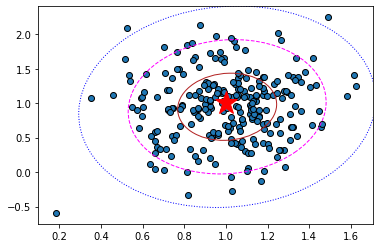

Mutation 3
Better individuals after mutation 127 / 250
Best score: -0.09800172367626361 | Worst: -82.3552823836624 | Mean -14.527399488881468



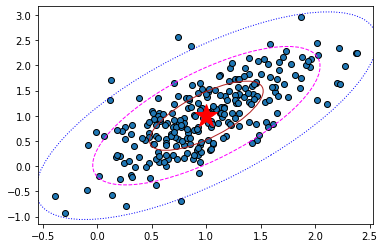

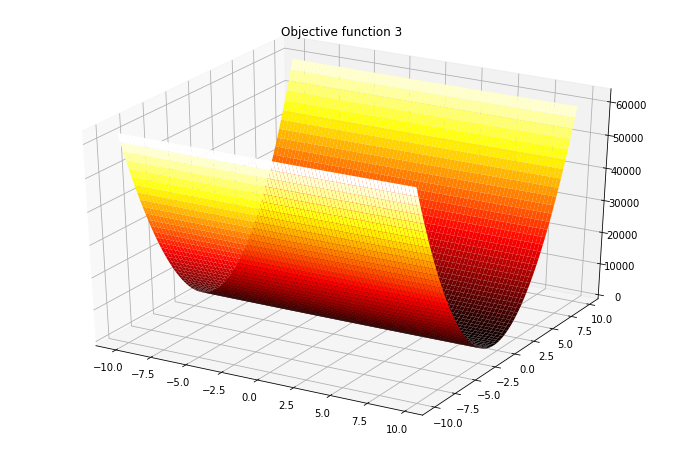

Mutation 1
Better individuals after mutation 128 / 250
Best score: -1.8118937709473513 | Worst: -28.204652719981784 | Mean -10.466152530142123



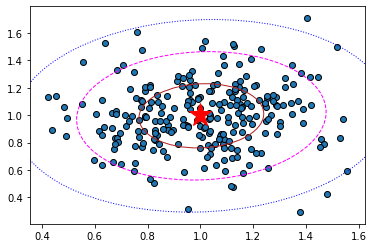

Mutation 2
Better individuals after mutation 130 / 250
Best score: -0.45726073319509974 | Worst: -47.65761767450104 | Mean -11.280615686159793



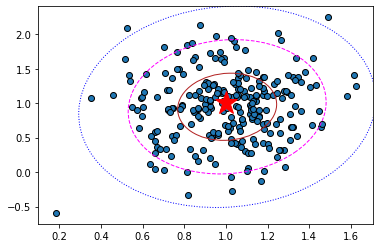

Mutation 3
Better individuals after mutation 127 / 250
Best score: -0.09800172367626361 | Worst: -82.3552823836624 | Mean -14.527399488881468



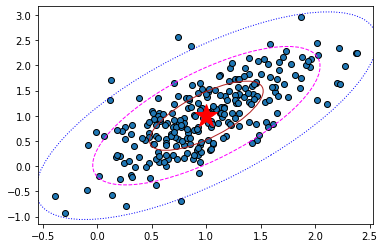

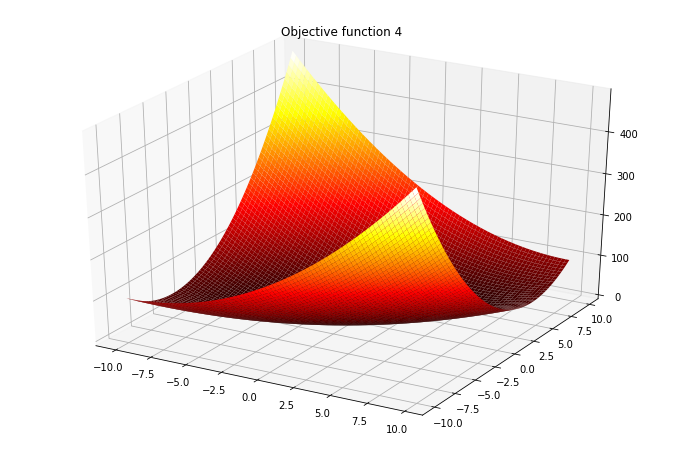

Mutation 1
Better individuals after mutation 128 / 250
Best score: -1.8118937709473513 | Worst: -28.204652719981784 | Mean -10.466152530142123



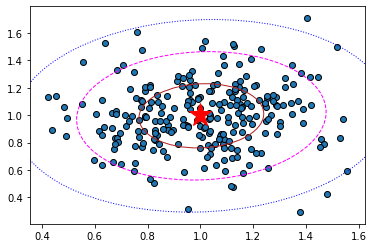

Mutation 2
Better individuals after mutation 130 / 250
Best score: -0.45726073319509974 | Worst: -47.65761767450104 | Mean -11.280615686159793



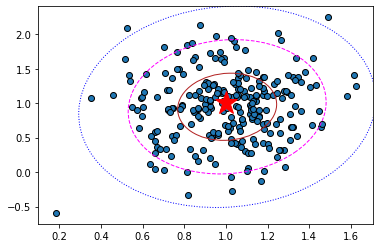

Mutation 3
Better individuals after mutation 127 / 250
Best score: -0.09800172367626361 | Worst: -82.3552823836624 | Mean -14.527399488881468



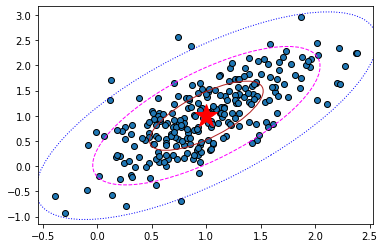

In [10]:
 for i, objective_function in enumerate(objective_functions):
    plot_3D_benchmark_function(
        objective_function = objective_function,
        domain_X = np.arange(-10, 10, 0.25), 
        domain_Y = np.arange(-10, 10, 0.25),
        title = f'Objective function {i + 1}'
    )
    for j, mutation in enumerate(mutations):
        print(f'Mutation {j + 1}')
        test_mutation(
            mutation=mutation,
            objective_function = objective_function_F1a,
            original_individual = original_individual
        )
        
        fig, ax = plt.subplots()
        ax.scatter(mutation[:, 0], mutation[:, 1], edgecolor='black')
        ax.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24, color='red')
        
        plot_elipses(
            ax=ax,
            mutations = mutation,
            original_individual = original_individual,
            n_std = 1,
            edgecolor='firebrick'
        )
        plot_elipses(
            ax=ax,
            mutations = mutation,
            original_individual = original_individual,
            n_std = 2,
            edgecolor='fuchsia', 
            linestyle='--'
        )
        plot_elipses(
            ax=ax,
            mutations = mutation,
            original_individual = original_individual,
            n_std = 3,
            edgecolor='blue', 
            linestyle=':'
        )
        plt.show()

## ES with mutations

In [184]:
def es(objective_function,
       chromosome_length,
       population_size, 
       number_of_iterations, 
       number_of_offspring, 
       number_of_parents, 
       sigma, 
       tau, 
       tau_0,
       log_frequency=1,
       mutation=None
):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(1, number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
            
        parent_indices = np.random.choice(
            population_size,
            (number_of_offspring, number_of_parents),
            True,
            fitness_values
        ).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas \
                                        * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) \
                                        + tau_0 * np.random.randn(number_of_offspring, 1))
        
        children_population_solutions += mutation(children_population_sigmas, number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([
            current_population_objective_values, 
            children_population_objective_values
        ])
        
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [
            current_population_objective_values.min(),
            current_population_objective_values.max(), 
            current_population_objective_values.mean(), 
            current_population_objective_values.std()
        ]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [185]:
def mutation0(sigma, N, d):
    return sigma * np.random.randn(N, d)


def mutation1(sigma, N, d):
    r = np.random.randint(N)
    return sigma[r, :] * np.random.randn(N, d)


def mutation2(sigma, N, d):
    return sigma.mean(axis=0) * np.random.randn(N, d)


def mutation3(sigma, N, d):
    sigma = np.cov(sigma.T)
    return np.dot(np.random.randn(N, d), np.linalg.cholesky(sigma).T)

In [192]:
def run_es(d, N, T, objective_function, mutation, log_every=10, sigma=50.0):
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
        objective_function, d, N, T, 2*N, 2, 
        sigma, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), log_every,
        mutation=mutation
    )
    print(f'BEST: {best_objective_value}')
    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 0])
    plt.plot(history_objective_values[:, 1])
    plt.plot(history_objective_values[:, 2])
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.legend(['Min','Mean', 'Max'], loc='upper right')
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.plot(history_best_sigmas)
    plt.xlabel('iteration')
    plt.ylabel('sigma value')
    plt.title('best sigmas')
    plt.show()

In [193]:
mutations = [mutation0, mutation1, mutation2, mutation3]
objective_functions = [
    objective_function_F1, 
    objective_function_F1a, 
    objective_function_F1b, 
    objective_function_F1c,
]

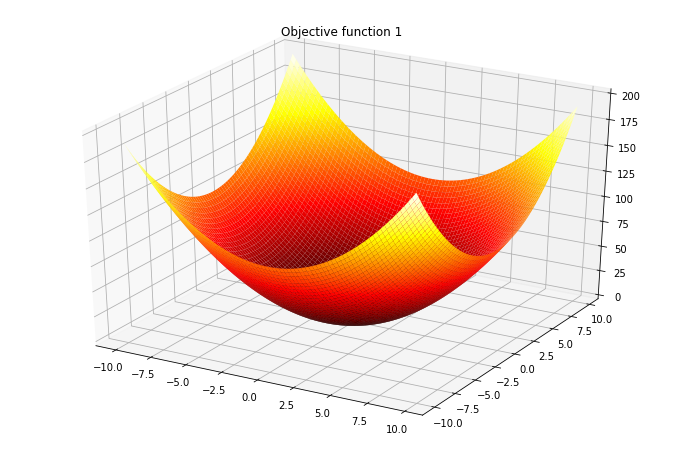

Mutation 1 | N = 2000 | d = 100 | T = 100
BEST: 0.0


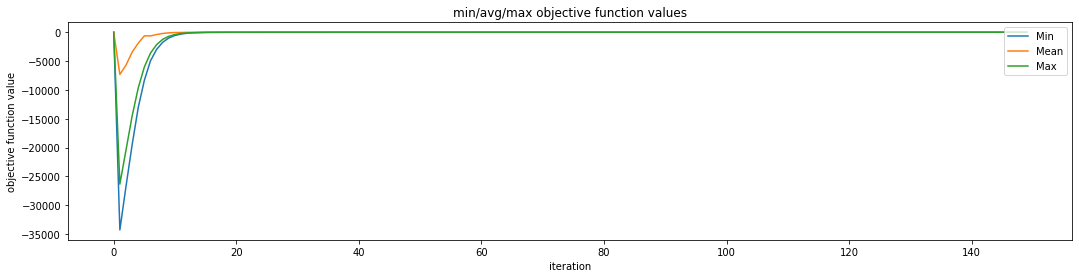

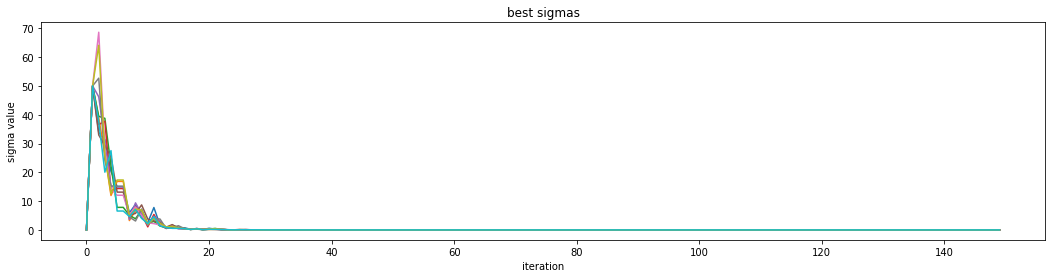


------------------------------------------------------

Mutation 2 | N = 2000 | d = 100 | T = 100
BEST: 0.0


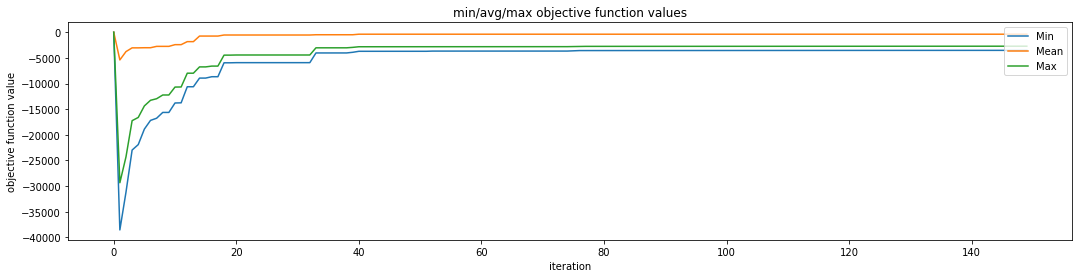

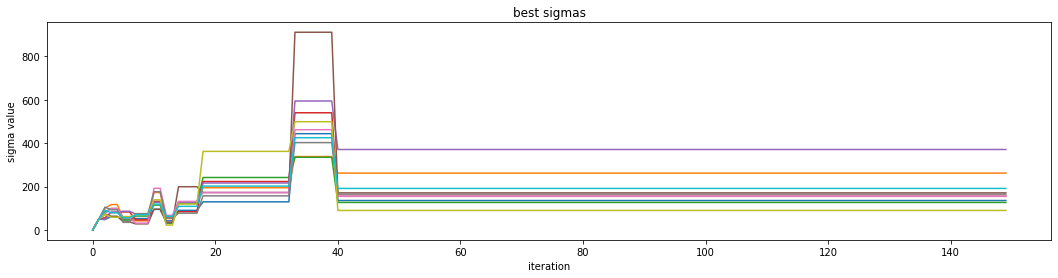


------------------------------------------------------

Mutation 3 | N = 2000 | d = 100 | T = 100
BEST: 0.0


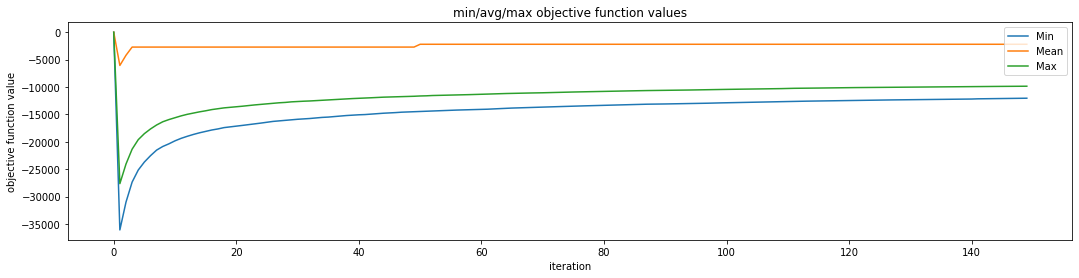

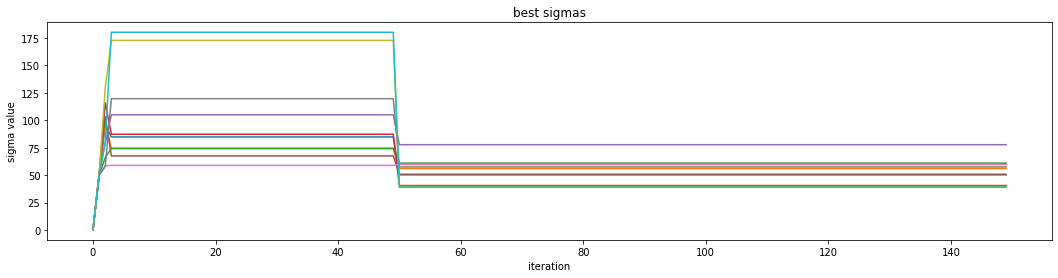


------------------------------------------------------

Mutation 4 | N = 2000 | d = 100 | T = 100
BEST: 0.0


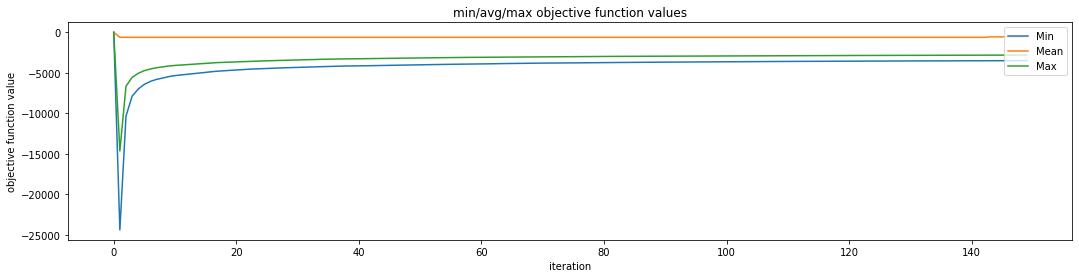

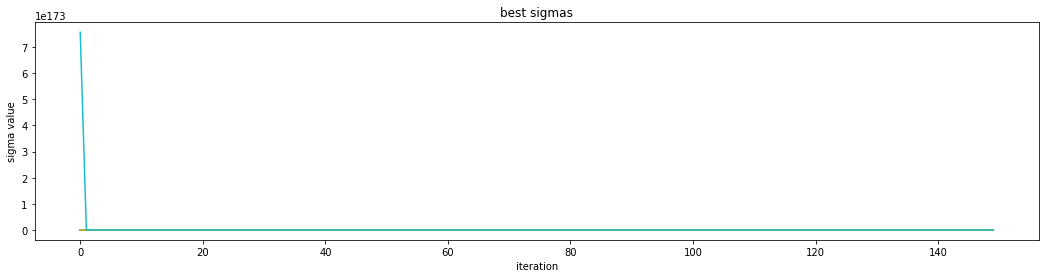


------------------------------------------------------



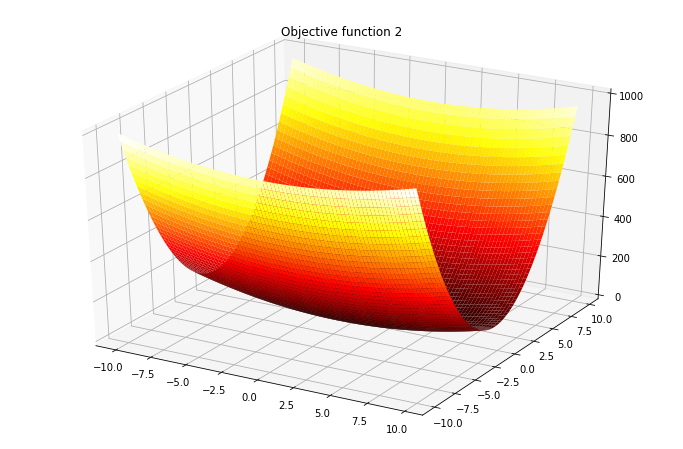

Mutation 1 | N = 2000 | d = 100 | T = 100
BEST: 0.0


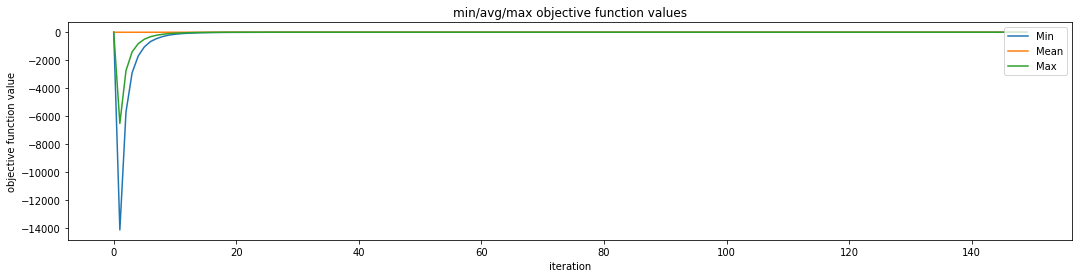

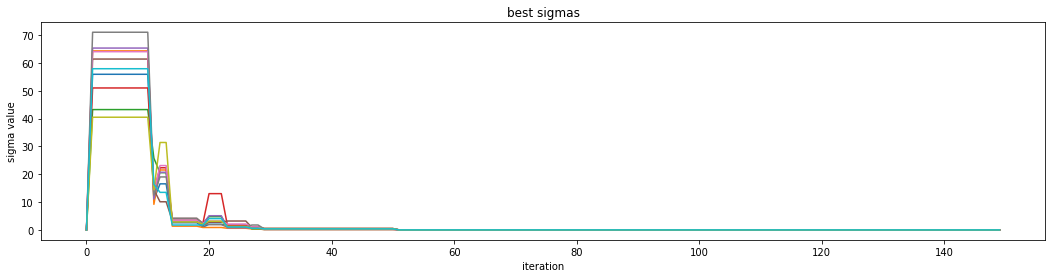


------------------------------------------------------

Mutation 2 | N = 2000 | d = 100 | T = 100
BEST: 0.0


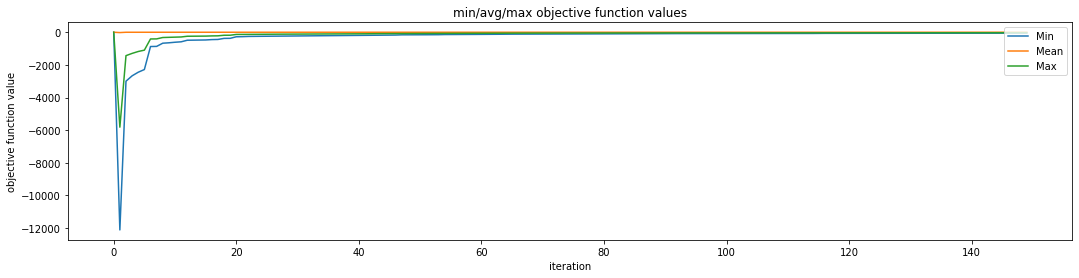

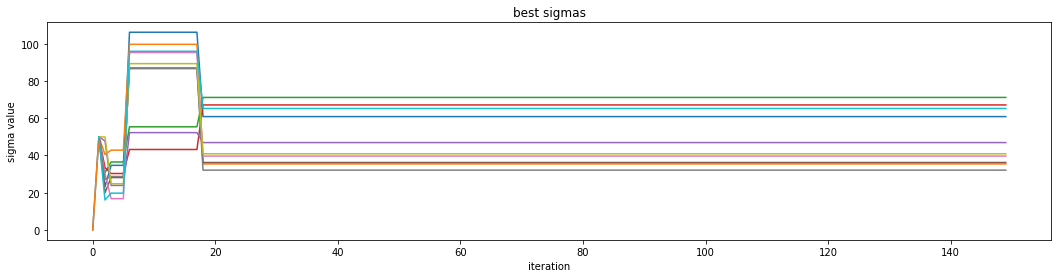


------------------------------------------------------

Mutation 3 | N = 2000 | d = 100 | T = 100
BEST: 0.0


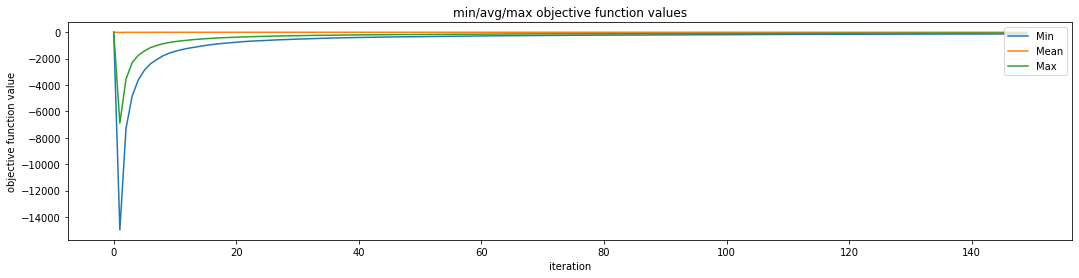

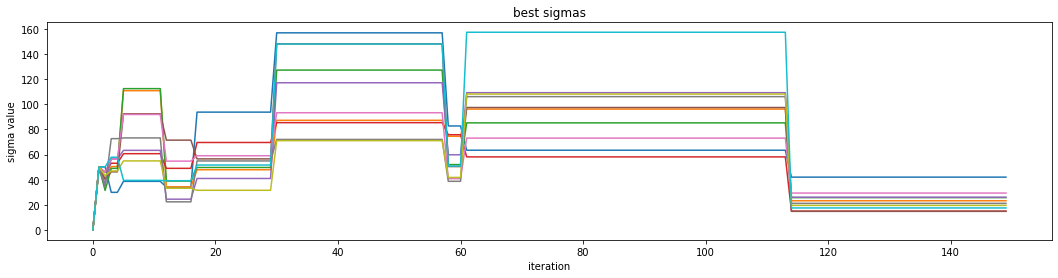


------------------------------------------------------

Mutation 4 | N = 2000 | d = 100 | T = 100
BEST: 0.0


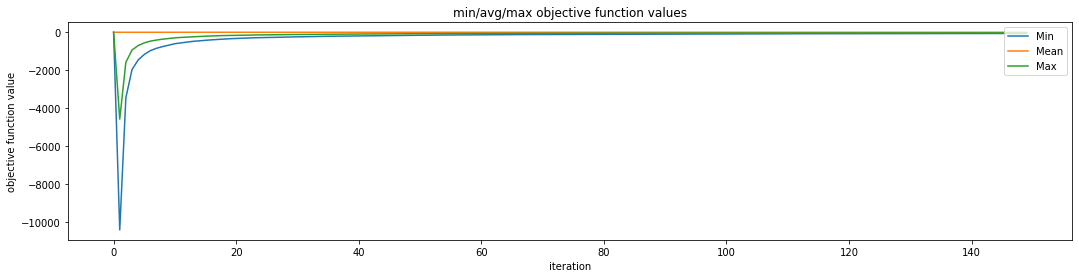

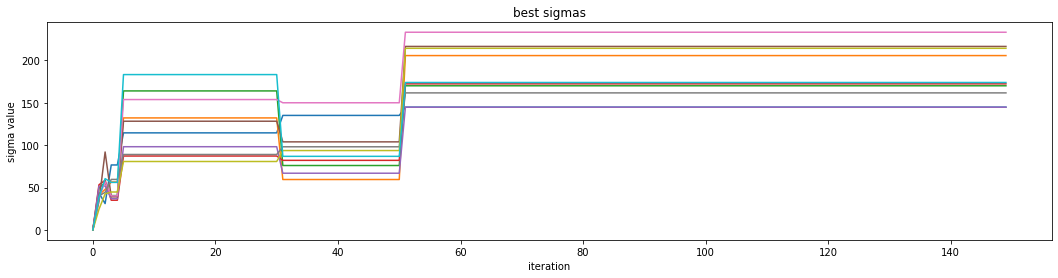


------------------------------------------------------



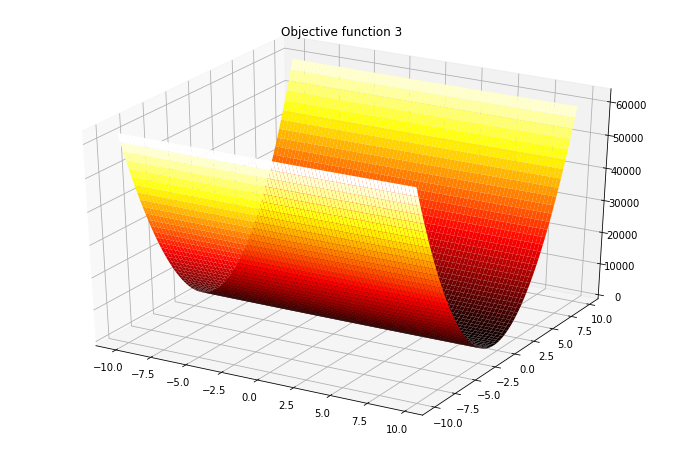

Mutation 1 | N = 2000 | d = 100 | T = 100
BEST: 0.0


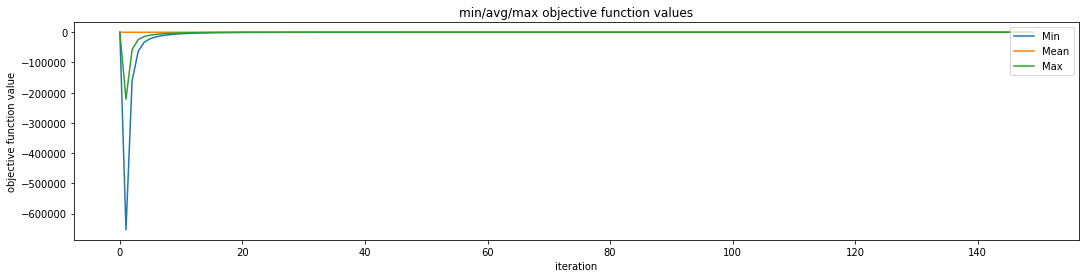

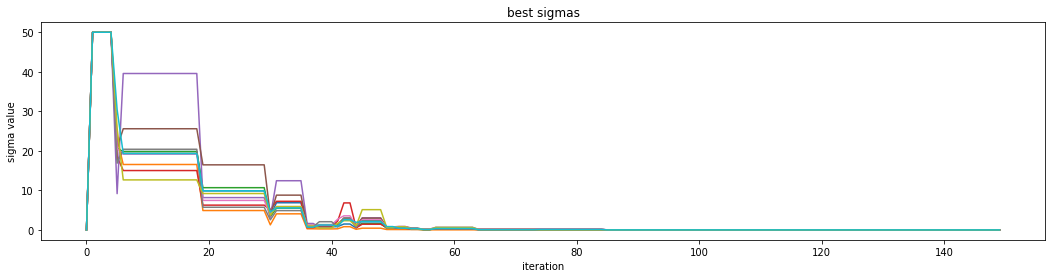


------------------------------------------------------

Mutation 2 | N = 2000 | d = 100 | T = 100
BEST: 0.0


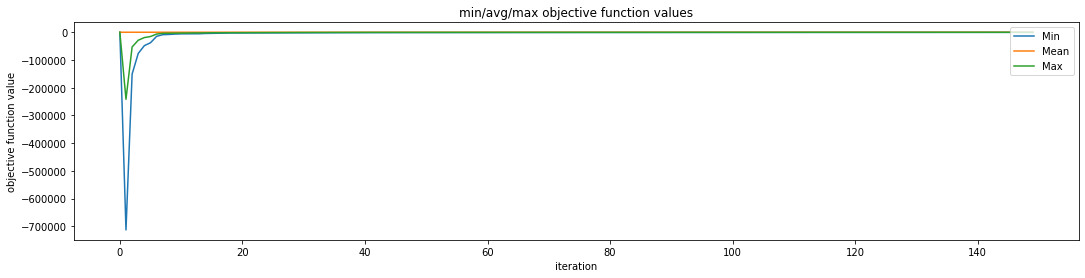

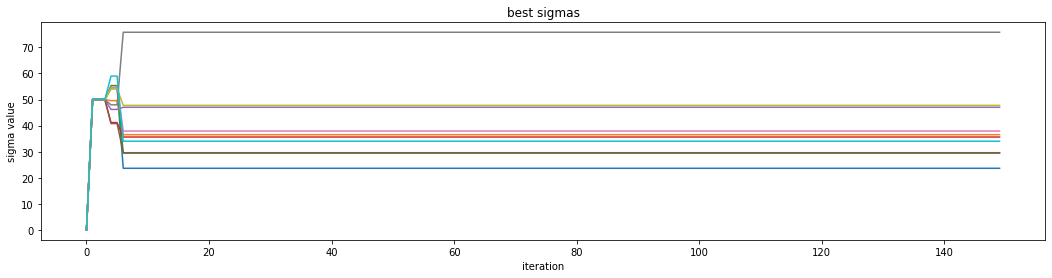


------------------------------------------------------

Mutation 3 | N = 2000 | d = 100 | T = 100
BEST: 0.0


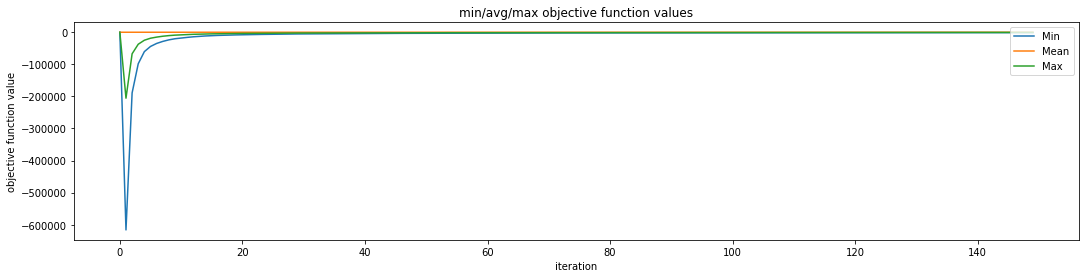

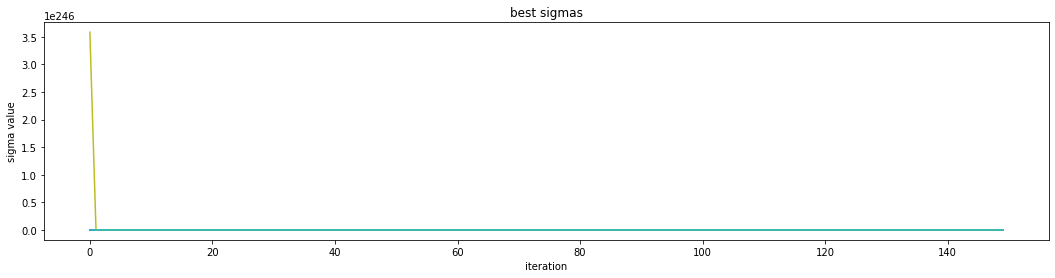


------------------------------------------------------

Mutation 4 | N = 2000 | d = 100 | T = 100
BEST: 0.0


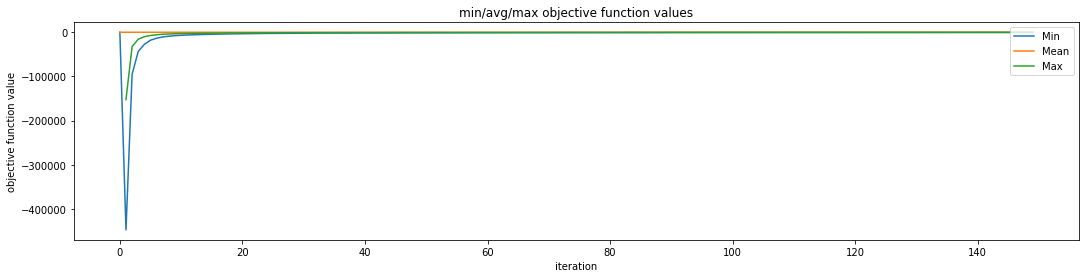

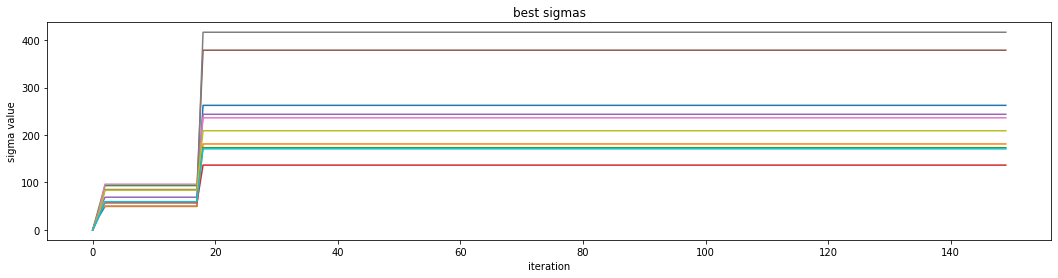


------------------------------------------------------



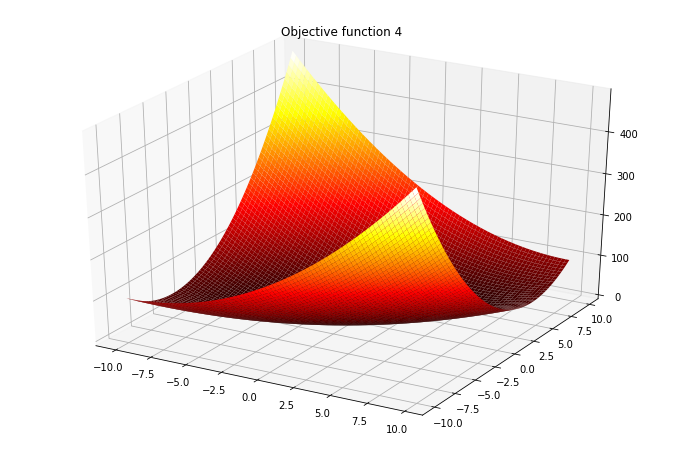

Mutation 1 | N = 2000 | d = 100 | T = 100
BEST: 0.0


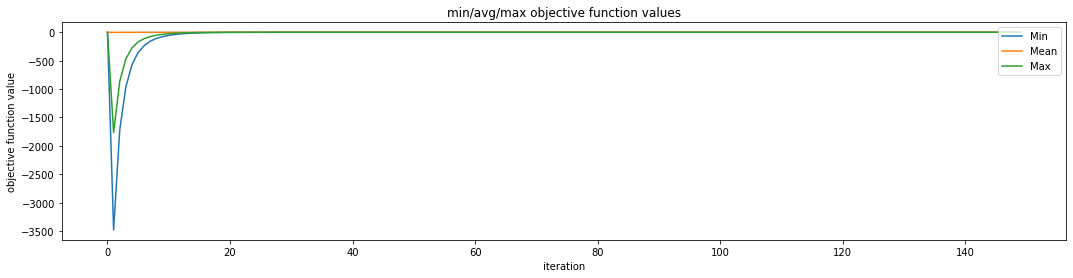

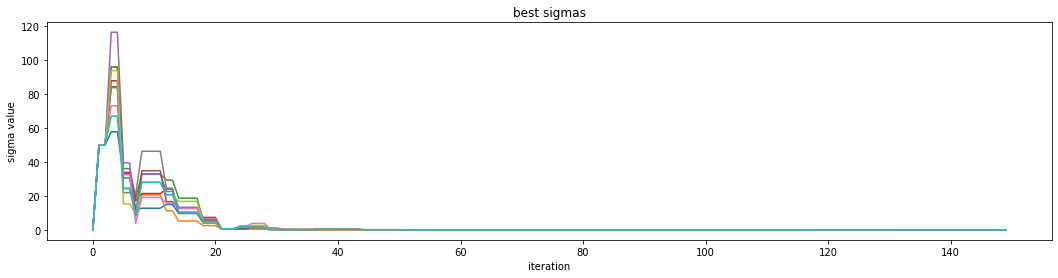


------------------------------------------------------

Mutation 2 | N = 2000 | d = 100 | T = 100
BEST: 0.0


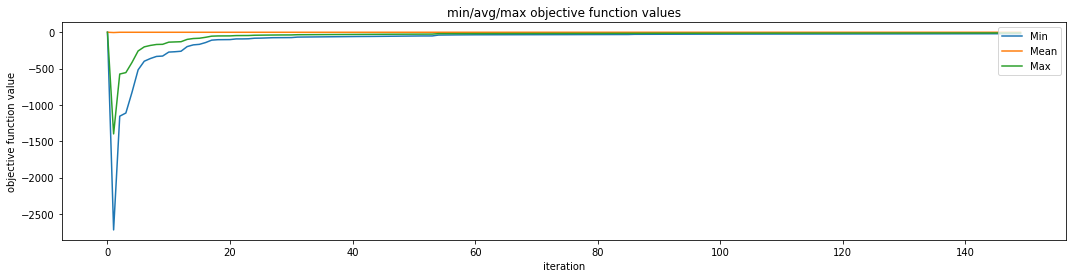

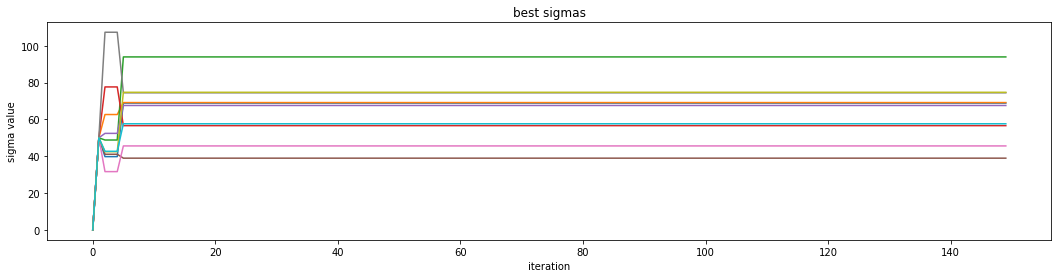


------------------------------------------------------

Mutation 3 | N = 2000 | d = 100 | T = 100
BEST: 0.0


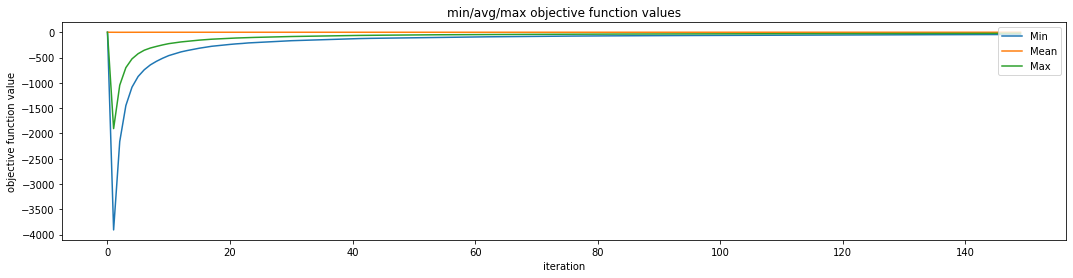

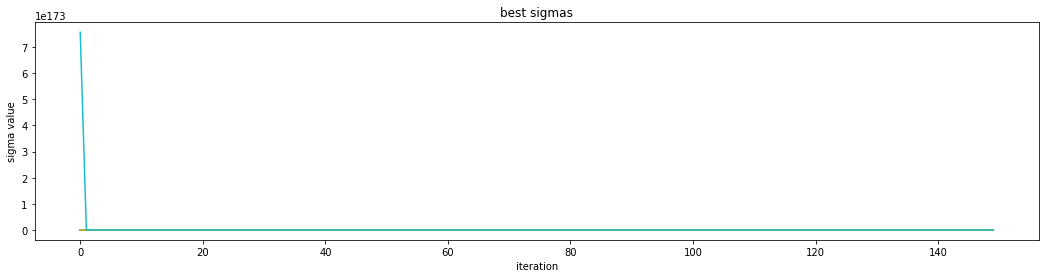


------------------------------------------------------

Mutation 4 | N = 2000 | d = 100 | T = 100
BEST: 0.0


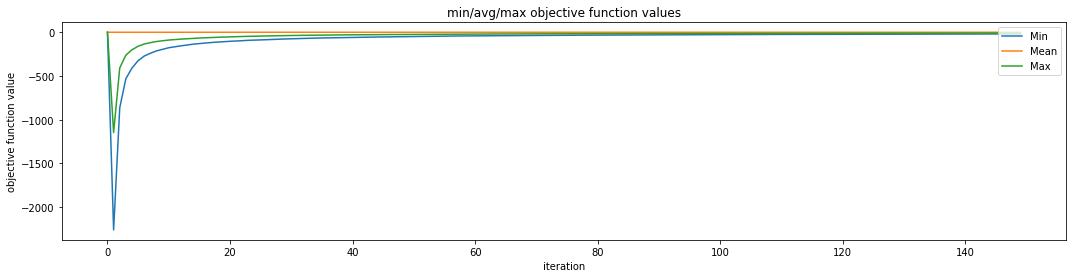

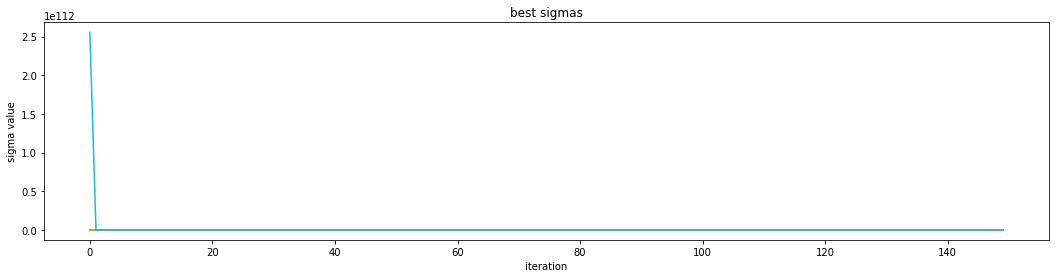


------------------------------------------------------



In [195]:
 for i, objective_function in enumerate(objective_functions):
    plot_3D_benchmark_function(
        objective_function = objective_function,
        domain_X = np.arange(-10, 10, 0.25), 
        domain_Y = np.arange(-10, 10, 0.25),
        title = f'Objective function {i + 1}'
    )
    for j, mutation in enumerate(mutations):
        N, d, T = 2000, 100, 100
        print(f'Mutation {j + 1} | N = {N} | d = {d} | T = {T}')
        run_es(
            d=10, N=2000, T=150, 
            objective_function=objective_function, 
            log_every=1e10, 
            mutation=mutation
        )
        print('\n------------------------------------------------------\n')